### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

,GlobalAttrTitle,GlobalAttrSource
0,MERRA-2 Global CDH,GES DISC
1,MERRA-2 Global PBLH,GES DISC
2,MERRA-2 Global TLML,GES DISC
3,MODIS Terra AOD 550 Dark Target Deep Blue Comb...,Giovanni
4,MODIS Terra Aerosol Optical Depth Land Ocean Mean,Giovanni
24,Sentinel-5P TROPOMI Methane CH4 California,GES DISC
25,Sentinel-5P TROPOMI Carbon Monoxide CO California,GES DISC
26,Sentinel-5P TROPOMI Tropospheric NO2 California,GES DISC
27,Sentinel-5P TROPOMI Total Ozone California,GES DISC
28,Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...,GES DISC


### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

,provider,project
0,AirNow,air_quality
1,AirNow,AQACF
2,GRIMM-Aethalometer,AQACF
3,PurpleAir,AQACF
4,QuantAQ,AQIC-Raw
5,QuantAQ,AQIC
6,QuantAQ,AQIC-Hourly
7,PurpleAir-GMU-Cal,air_quality
8,PurpleAir-GMU-Intermediate,air_quality
9,PurpleAir-GMU-Raw-Hourly,air_quality


In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

,index,platform,platform_short_name,lat,lon,min_datetime,max_datetime
0,0,000010102,St. John's,47.652800,-52.816700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
1,1,000010401,Mount Pearl,47.505000,-52.794700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
2,2,000010501,Grand Falls Windsor,49.019400,-55.802800,2018-01-01T00:00:00Z,2021-03-31T00:00:00Z
3,3,000010601,Goose Bay,53.304700,-60.364400,2018-01-02T00:00:00Z,2024-03-31T00:00:00Z
4,4,000010602,MacPherson Avenue - Corner Brook,48.952240,-57.922070,2020-01-01T00:00:00Z,2022-02-28T00:00:00Z
...,...,...,...,...,...,...,...
3471,7059,TT1010003,Inchelium,48.296960,-118.202420,2018-01-09T00:00:00Z,2019-05-31T00:00:00Z
3472,7060,TT5420500,Santa Rosa Rancheria,36.233333,-119.765083,2018-01-01T00:00:00Z,2023-08-24T00:00:00Z
3473,7062,TT9209004,Miami,36.922222,-94.838890,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z
3474,7064,UB1010001,Ulaanbaatar,47.928385,106.929470,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z


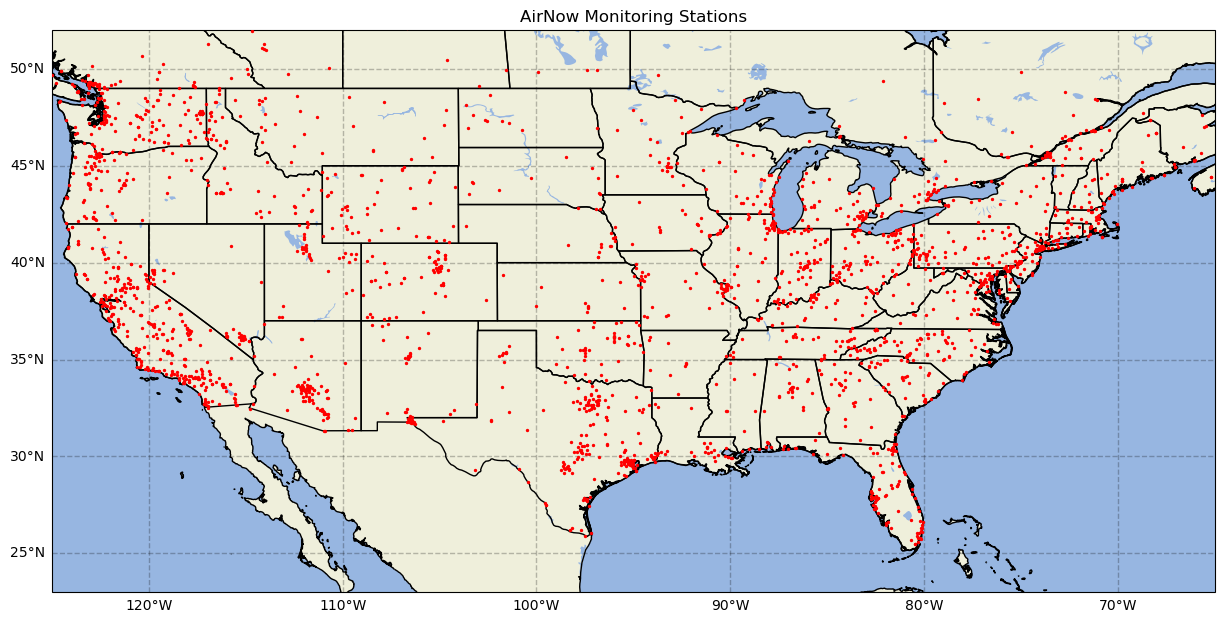

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# Predicting What We Breathe (PWWB)

In [8]:
pwwb_bb = {
    'min_lon': -120,
    'max_lon': -117,
    'min_lat': 32,
    'max_lat': 35
}

## PM2.5 Predictions

In [9]:
pwwb_PM25 = 'PWWB_200_daily_PM25'
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_PM25)
pwwb_pm25_data = firealarm_processing.data_subsetting(pwwb_PM25, pwwb_bb, pwwb_end_time - timedelta(days=1), pwwb_end_time, 'particulate_matter_25')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=PWWB_200_daily_PM25&b=-120%2C32%2C-117%2C35&startTime=2025-02-24T00%3A00%3A00Z&endTime=2025-02-25T00%3A00%3A00Z

Waiting for response from FireAlarm...took 2.776420166999742 seconds


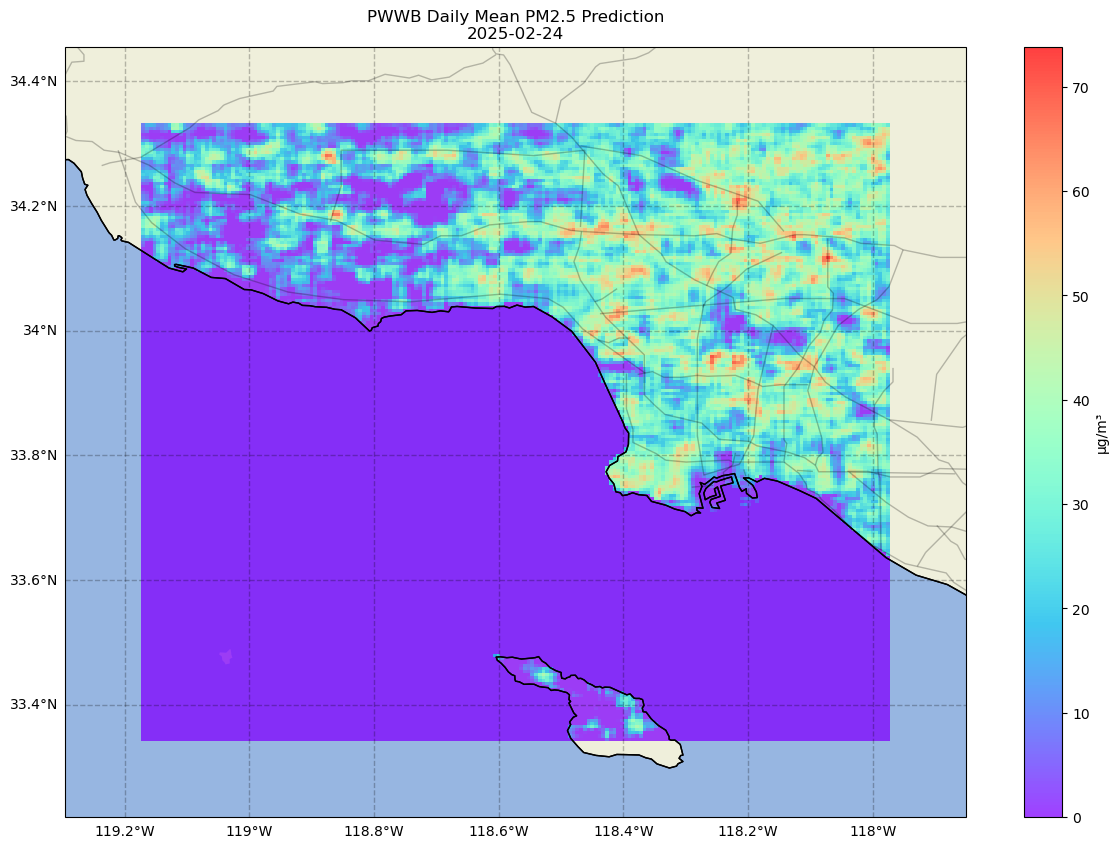

In [10]:
plotting.map_data(pwwb_pm25_data[0], f'PWWB Daily Mean PM2.5 Prediction\n{str(pwwb_pm25_data[0].time.values)[:10]}', padding=0.125, cb_label='µg/m³')

## NO2 Predictions

In [11]:
pwwb_NO2 = 'PWWB_200_daily_NO2'
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_NO2)
pwwb_no2_data = firealarm_processing.data_subsetting(pwwb_NO2, pwwb_bb, pwwb_end_time - timedelta(2), pwwb_end_time, 'nitrogen_dioxide')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=PWWB_200_daily_NO2&b=-120%2C32%2C-117%2C35&startTime=2025-02-23T00%3A00%3A00Z&endTime=2025-02-25T00%3A00%3A00Z

Waiting for response from FireAlarm...took 2.3336649580014637 seconds


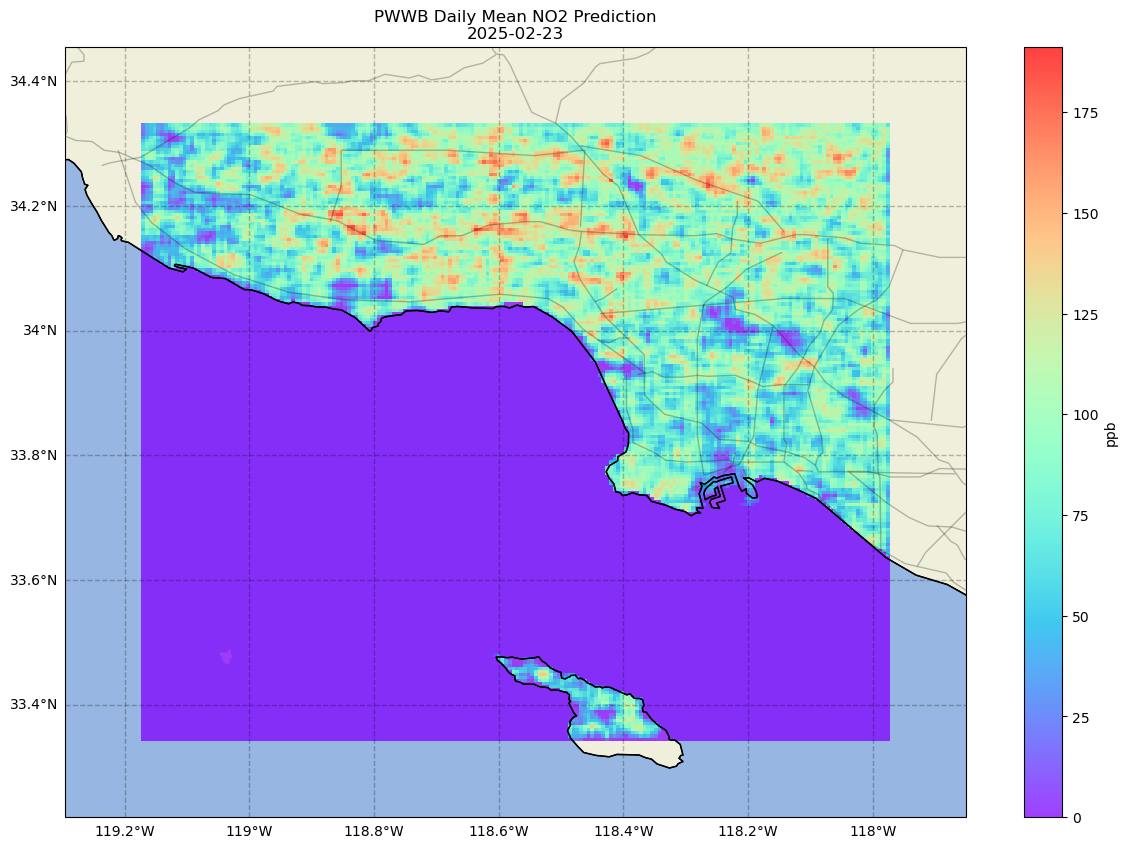

In [12]:
plotting.map_data(pwwb_no2_data[-1], f'PWWB Daily Mean NO2 Prediction\n{str(pwwb_no2_data[-1].time.values)[:10]}', padding=0.125, cb_label='ppb')

## O3 Predictions

In [13]:
pwwb_O3 = 'PWWB_200_daily_O3'
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_O3)
pwwb_o3_data = firealarm_processing.data_subsetting(pwwb_O3, pwwb_bb, pwwb_end_time - timedelta(1), pwwb_end_time, 'ozone')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=PWWB_200_daily_O3&b=-120%2C32%2C-117%2C35&startTime=2025-02-24T00%3A00%3A00Z&endTime=2025-02-25T00%3A00%3A00Z

Waiting for response from FireAlarm...took 2.2883008749995497 seconds


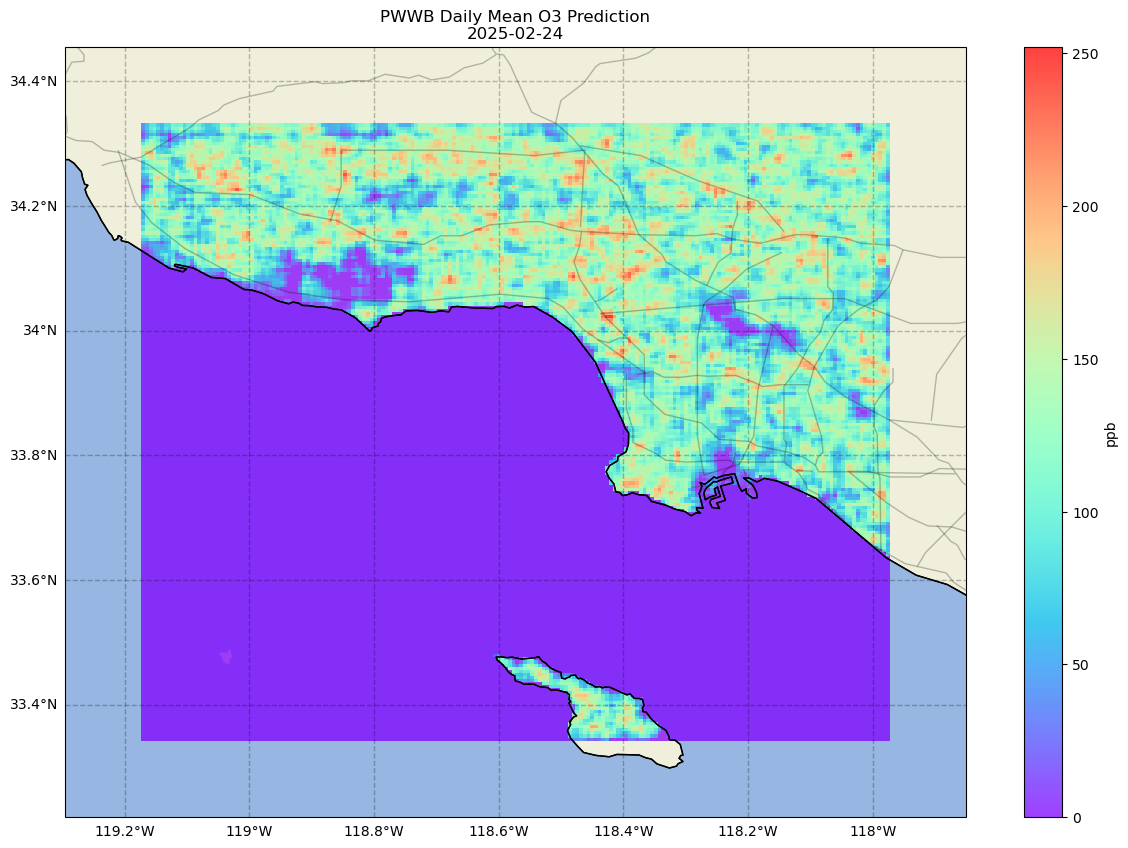

In [14]:
plotting.map_data(pwwb_o3_data[-1], f'PWWB Daily Mean O3 Prediction\n{str(pwwb_o3_data[-1].time.values)[:10]}', padding=0.125, cb_label='ppb')

## NO Predictions

In [15]:
pwwb_NO = 'PWWB_200_daily_NO'
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_NO)
pwwb_no_data = firealarm_processing.data_subsetting(pwwb_NO, pwwb_bb, pwwb_end_time - timedelta(1), pwwb_end_time, 'nitric_oxide')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=PWWB_200_daily_NO&b=-120%2C32%2C-117%2C35&startTime=2025-02-24T00%3A00%3A00Z&endTime=2025-02-25T00%3A00%3A00Z

Waiting for response from FireAlarm...took 2.125873959001183 seconds


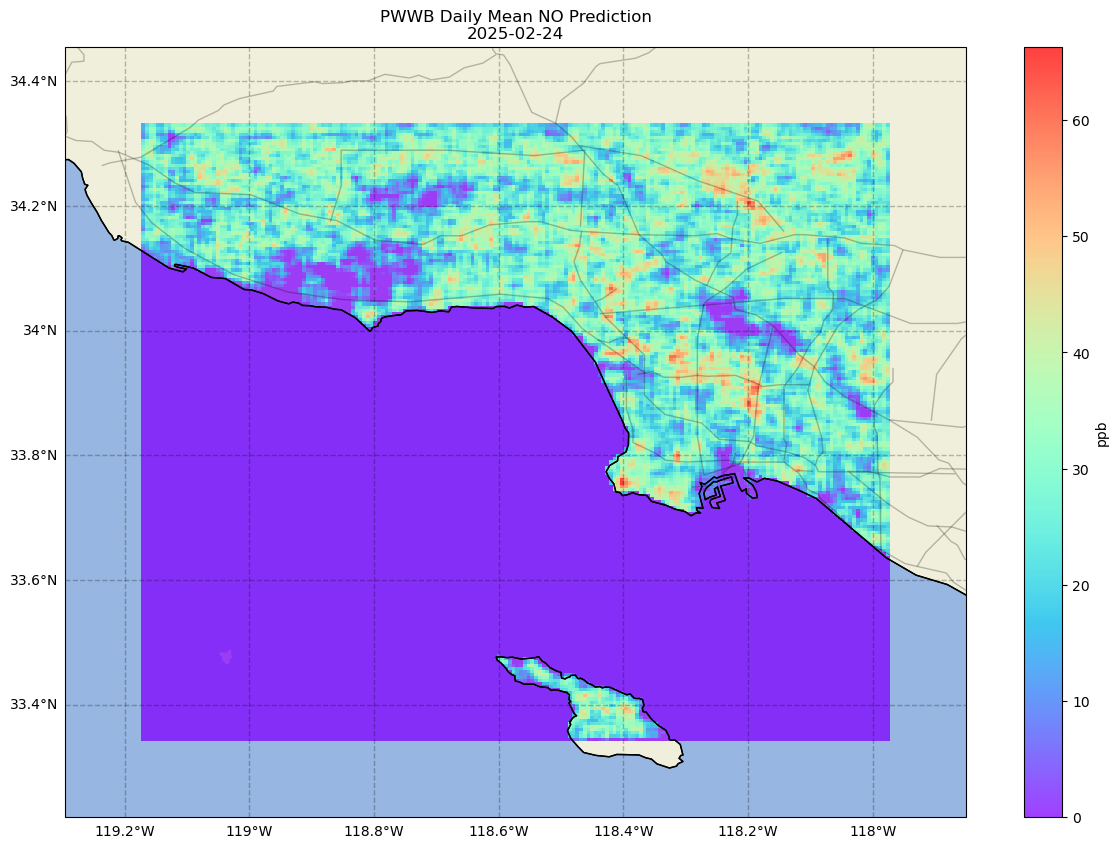

In [16]:
plotting.map_data(pwwb_no_data[-1], f'PWWB Daily Mean NO Prediction\n{str(pwwb_no_data[-1].time.values)[:10]}', padding=0.125, cb_label='ppb')

## CO Predictions

In [17]:
pwwb_CO = 'PWWB_200_daily_CO'
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_CO)
pwwb_co_data = firealarm_processing.data_subsetting(pwwb_CO, pwwb_bb, pwwb_end_time - timedelta(10), pwwb_end_time, 'carbon_monoxide')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=PWWB_200_daily_CO&b=-120%2C32%2C-117%2C35&startTime=2025-02-13T00%3A00%3A00Z&endTime=2025-02-23T00%3A00%3A00Z

Waiting for response from FireAlarm...took 2.5826170000000275 seconds


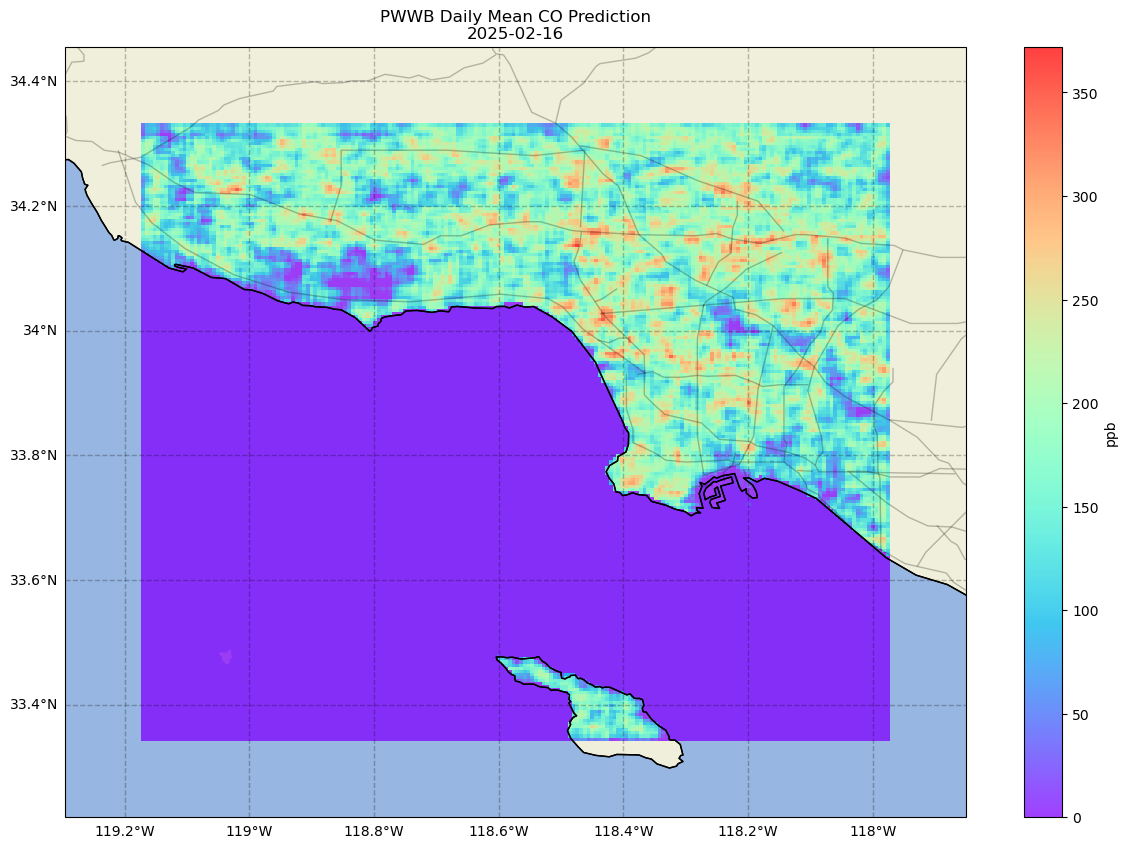

In [18]:
plotting.map_data(pwwb_co_data[-1], f'PWWB Daily Mean CO Prediction\n{str(pwwb_co_data[-1].time.values)[:10]}', padding=0.125, cb_label='ppb')

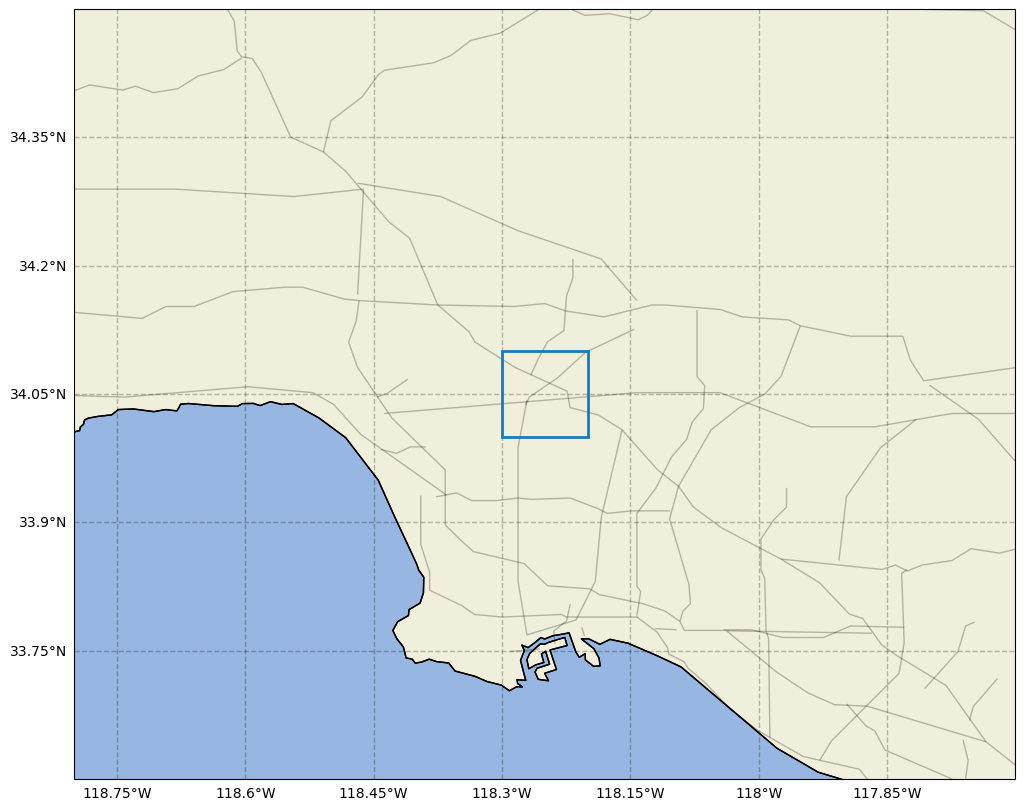

In [19]:
dtla_bb = {
    'min_lon': -118.3,
    'max_lon': -118.2,
    'min_lat': 34.1,
    'max_lat': 34
}
plotting.map_box(dtla_bb, padding=.5)

In [20]:
pwwb_start_time, pwwb_end_time = firealarm_processing.get_date_coverage(pwwb_PM25)
pwwb_dtla_timeseries = firealarm_processing.spatial_timeseries(pwwb_PM25, dtla_bb,  pwwb_end_time - timedelta(7), pwwb_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=PWWB_200_daily_PM25&minLon=-118.3&minLat=34.1&maxLon=-118.2&maxLat=34&startTime=2025-02-18T00%3A00%3A00Z&endTime=2025-02-25T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 9.507742624999082 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


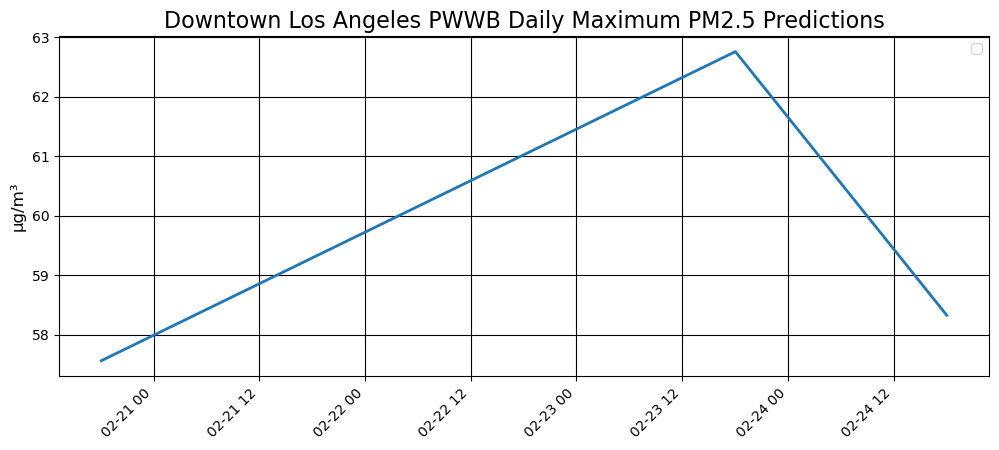

In [21]:
plotting.timeseries_plot([(pwwb_dtla_timeseries['maximum'], '')], '', 'µg/m³', 'Downtown Los Angeles PWWB Daily Maximum PM2.5 Predictions')